# Atividade 4 - CNN

Nessa atividade foi explorado os conceitos das cnns, para isso eu fiz uso do tensorflow e do fastai. Para realizar os teste foi utilizado o dataset com imagens de pandas, gatos e cachorros.

---

## Preparando o Ambiente

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
data_dir = '/kaggle/input/animals/animals'

Inicialmente foi necessário processar as imagens usando o ImageDataGenerator do tensorflow.

In [4]:
batch_size = 32
image_size = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## Criando o Modelo

A arquitetura do modelo possuí duas camadas de convolução, duas camadas de maxpooling e duas camadas densas. As funções de ativação utilizadas foram relu e softmax.

In [12]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
75/75 [==============================] - 47s 592ms/step - loss: 1.0899 - accuracy: 0.5096 - val_loss: 0.8727 - val_accuracy: 0.5450
Epoch 2/10
75/75 [==============================] - 43s 574ms/step - loss: 0.8308 - accuracy: 0.5713 - val_loss: 0.8684 - val_accuracy: 0.5600
Epoch 3/10
75/75 [==============================] - 44s 588ms/step - loss: 0.7956 - accuracy: 0.5929 - val_loss: 0.8358 - val_accuracy: 0.5750
Epoch 4/10
75/75 [==============================] - 43s 577ms/step - loss: 0.8057 - accuracy: 0.5921 - val_loss: 0.8058 - val_accuracy: 0.5733
Epoch 5/10
75/75 [==============================] - 44s 581ms/step - loss: 0.7817 - accuracy: 0.5938 - val_loss: 0.8516 - val_accuracy: 0.5667
Epoch 6/10
75/75 [==============================] - 43s 573ms/step - loss: 0.7723 - accuracy: 0.6071 - val_loss: 0.8113 - val_accuracy: 0.5783
Epoch 7/10
75/75 [==============================] - 24s 324ms/step - loss: 0.7494 - accuracy: 0.6133 - val_loss: 0.7498 - val_accuracy: 0.6150

Com esse modelo conseguimos chegar em uma acuracia de 60%.

In [ ]:
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
print(confusion_mtx)

---
# Com o Fastai

Para tentar melhorar o resultado eu utilizei a biblioteca Fastai

In [ ]:
!pip install fastai

In [4]:
from fastai.vision.all import *

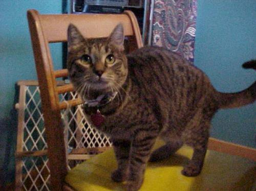

In [5]:
base_path = '/kaggle/input/animals/animals'
path = Path('/kaggle/input/animals/animals')
im = Image.open(base_path+'/cats/cats_00001.jpg')
im.to_thumb(256,256)

Com esse bibliotaca conseguimos criar o datablock para o nosso dado, nesse datablock conseguimos definir algumas opções do dado, como a divisão entre teste e treino, o tamanho e a forma como a imagem vai ser redimensionada.

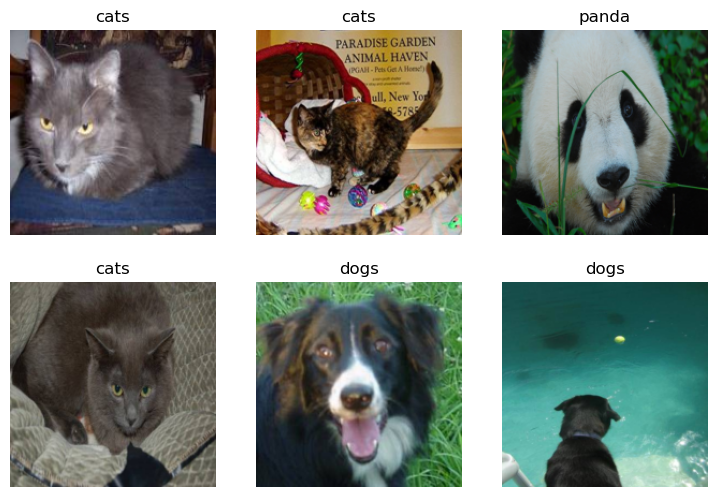

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192,method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.332046,0.070648,0.026667,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.114366,0.069571,0.023333,00:32
1,0.080106,0.053161,0.013333,00:32
2,0.036105,0.050909,0.016667,00:32


Por fim, geramos uma matriz de confusão para verificar os resultados com mais clareza e podemos observar que o modelo teve um desempenho muito bom, errando apenas 10 amostras de 600.

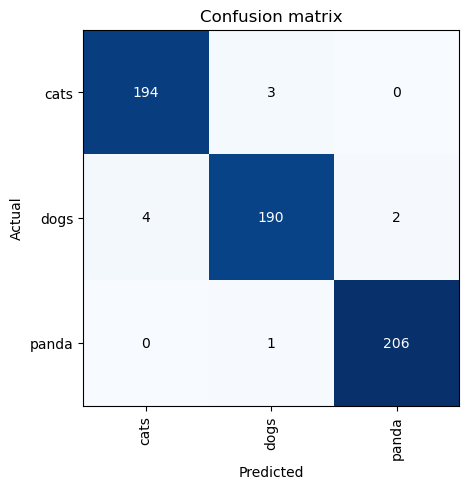

In [10]:
matriz = ClassificationInterpretation.from_learner(learn)
matriz.plot_confusion_matrix()